# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

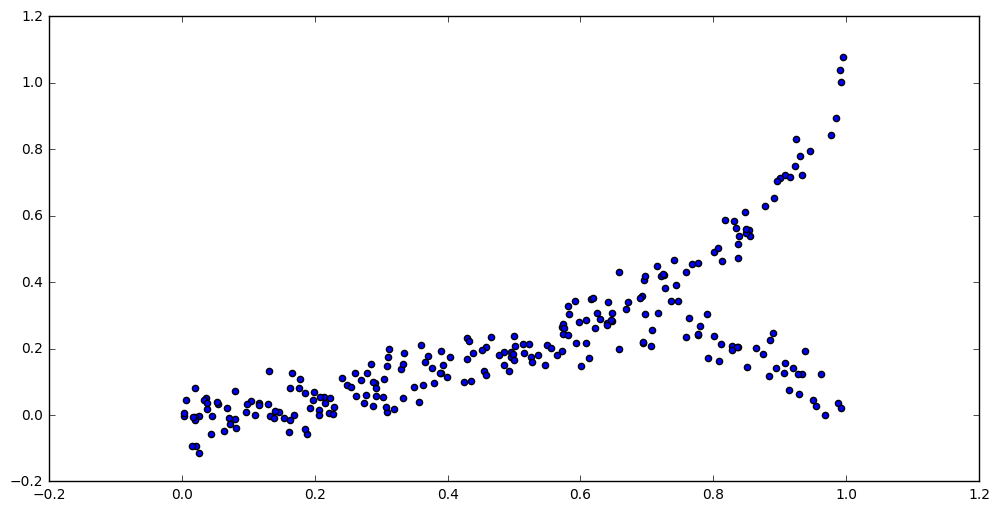

In [3]:
plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, variance=0.01, prior_Z='DP')
m.log_likelihood()

1169.0219964442294

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

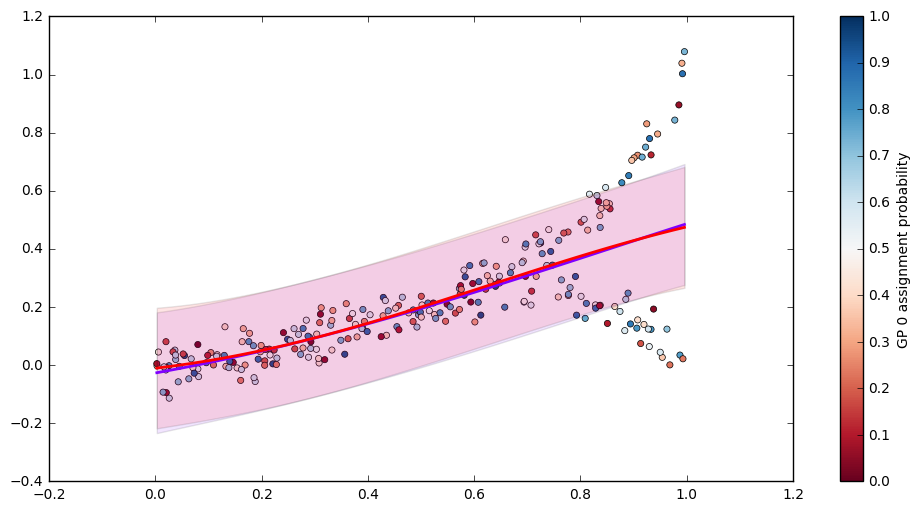

In [5]:
from plotter import OMGPplot
OMGPplot(m,X,Y)

There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

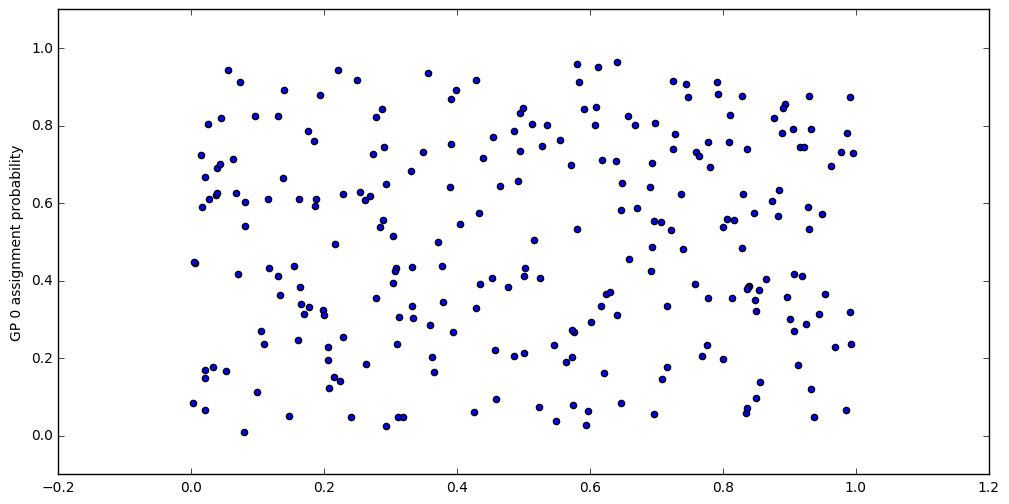

In [6]:
from plotter import OMGPplot_probs
OMGPplot_probs(m, X, gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [7]:
m.optimize(step_length=0.01, maxiter=20)

ValueError: Shapes (?,) and () are not compatible

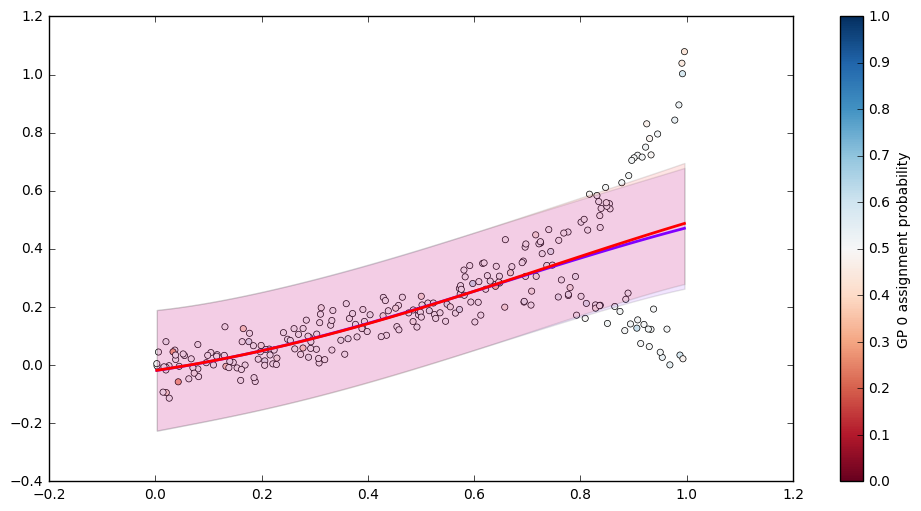

In [8]:
OMGPplot(m,X,Y)

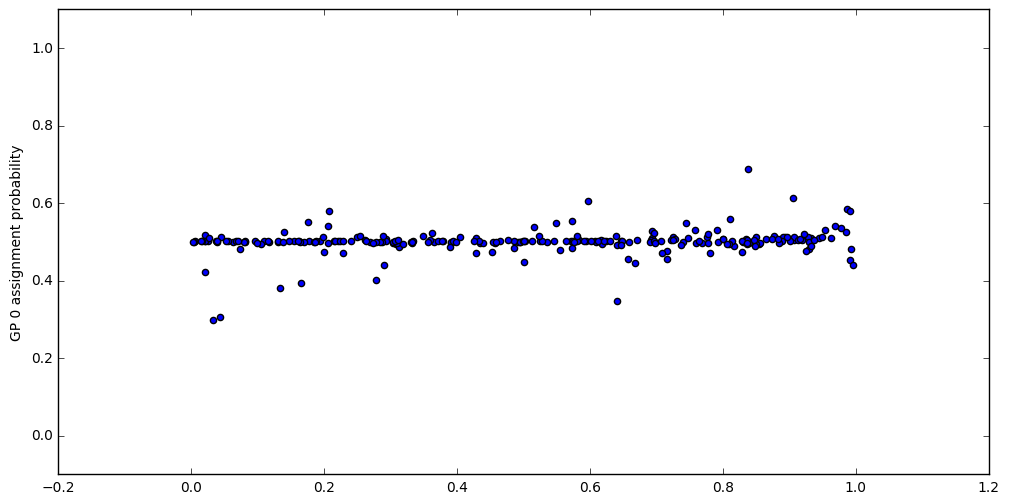

In [9]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [10]:
print 'Variance = ', m.get_variance()
m

Variance =  0.01


Name,values,prior,constraint
model.kern.item0.variance,[ 1.],None,+ve
model.kern.item0.lengthscales,[ 1.],None,+ve
model.kern.item1.lengthscales,[ 1.],None,+ve
model.kern.item1.variance,[ 1.],None,+ve


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [11]:
m.optimize(step_length=0.01, maxiter=200)

iteration 1 bound=1258.71083457 grad=4.1992385394, beta=0
iteration 2 bound=1258.79012207 grad=4.03100265974, beta=0.981588037325
iteration 3 bound=1258.89899046 grad=3.71075005197, beta=0.962784621203
iteration 4 bound=1259.02639474 grad=3.27172319321, beta=0.943298699017
iteration 5 bound=1259.160098 grad=2.75901678348, beta=0.922944748525
iteration 6 bound=1259.28863285 grad=2.22229552874, beta=0.901707604576
iteration 7 bound=1259.40302289 grad=1.70781011496, beta=0.879744744199
iteration 8 bound=1259.49783436 grad=1.25150345705, beta=0.857348819869
iteration 9 bound=1259.57132888 grad=0.874878613695, beta=0.834879414995
iteration 10 bound=1259.62480266 grad=0.584494398099, beta=0.812688952647
iteration 11 bound=1259.6614599 grad=0.374716782344, beta=0.791072489411
iteration 12 bound=1259.68524453 grad=0.232316927151, beta=0.770262592253
iteration 13 bound=1259.69994297 grad=0.141205268536, beta=0.750476557607
iteration 14 bound=1259.70867697 grad=0.0860444748763, beta=0.7320165645

In [13]:
print m.get_variance()
m

0.01


Name,values,prior,constraint
model.kern.item0.variance,[ 0.08827016],None,+ve
model.kern.item0.lengthscales,[ 1.15022591],None,+ve
model.kern.item1.lengthscales,[ 1.20568574],None,+ve
model.kern.item1.variance,[ 0.11894312],None,+ve


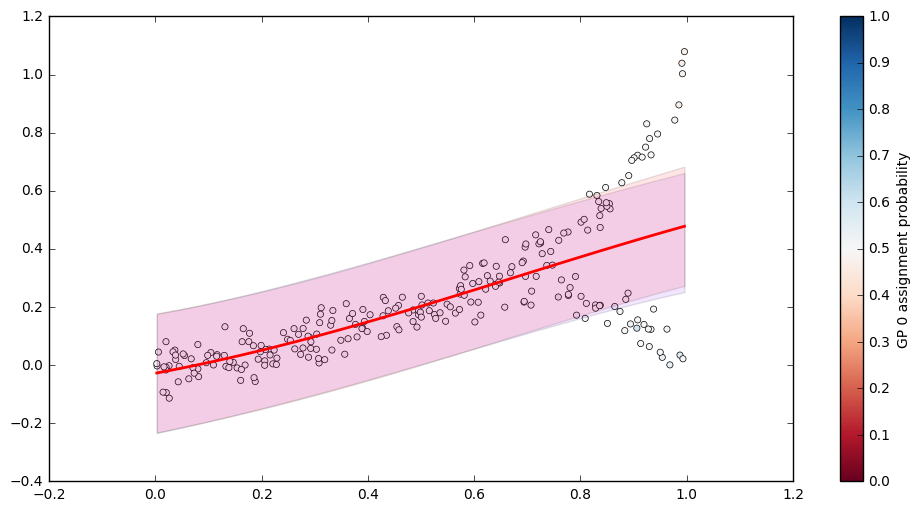

In [16]:
OMGPplot(m,X,Y)

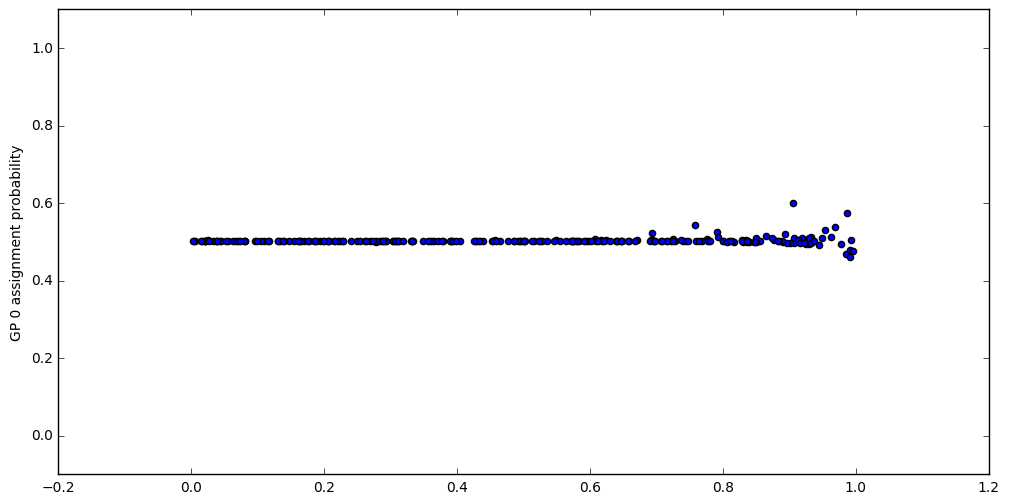

In [17]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [18]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

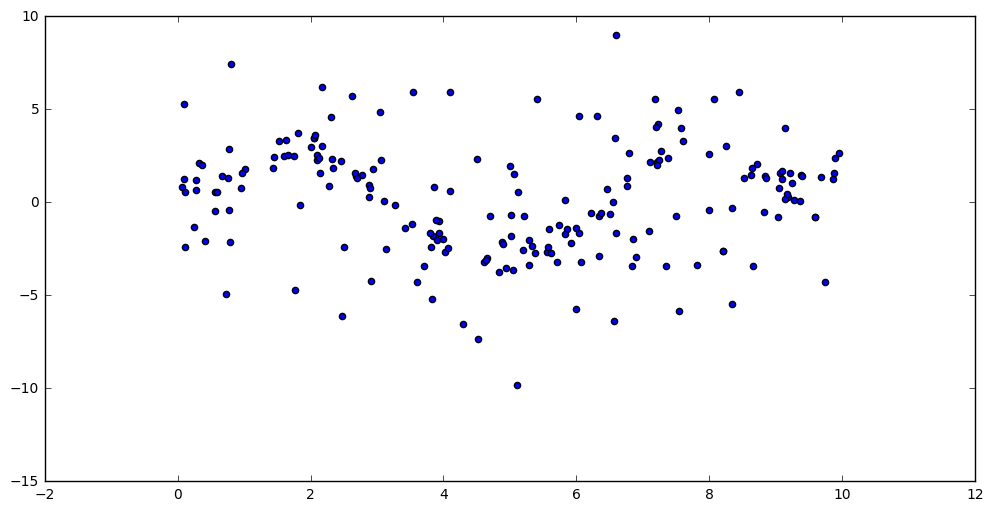

In [19]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [20]:
kernels = [GPflow.kernels.RBF(1,lengthscales=2.0)]
m = OMGP(x, y, num_clusters=1, prior_Z='DP', kernels=kernels,variance=3.)
m.hyperparam_interval = 100

In [21]:
m.optimize(verbose=False)

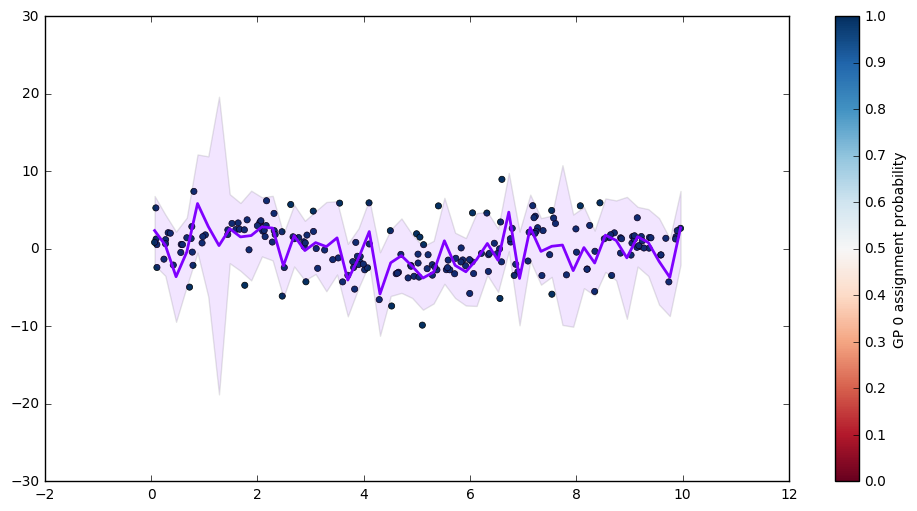

In [22]:
OMGPplot(m,x,y)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [23]:
kernels = [GPflow.kernels.White(1), GPflow.kernels.RBF(1, lengthscales=2.0)]
m = OMGP(x, y, num_clusters=2, prior_Z='DP', kernels=kernels, variance=3.)
m.hyperparam_interval = 250

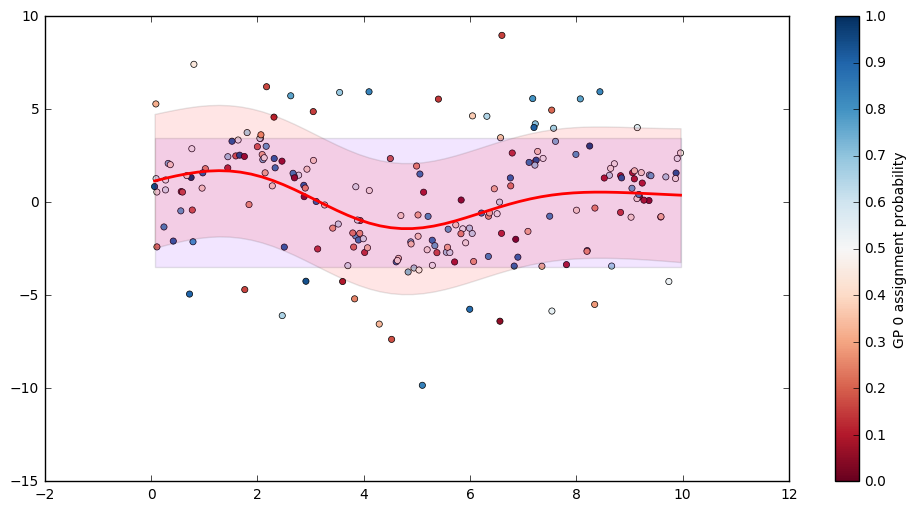

In [24]:
OMGPplot(m,x,y)

In [27]:
m.optimize(step_length=0.01, verbose=False)

InvalidArgumentError: Input matrix is not invertible.
	 [[Node: model.build_likelihood_12/MatrixTriangularSolve_1 = MatrixTriangularSolve[T=DT_DOUBLE, adjoint=false, lower=true, _device="/job:localhost/replica:0/task:0/cpu:0"](model.build_likelihood_12/Cholesky_1, _recv_unnamed_11_0)]]
Caused by op u'model.build_likelihood_12/MatrixTriangularSolve_1', defined at:
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-6dd6f3f6a7eb>", line 1, in <module>
    m.optimize(step_length=0.01, verbose=False)
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_vb.py", line 139, in optimize
    if self.optimize_parameters() < 1e-1:
  File "/Users/danmarthaler/GPclust/GPclust/collapsed_vb.py", line 173, in optimize_parameters
    GPflow.model.Model.optimize(self, **self.hyperparam_opt_args)
  File "/Users/danmarthaler/GPflow/GPflow/model.py", line 218, in optimize
    return self._optimize_np(method, tol, callback, maxiter, **kw)
  File "/Users/danmarthaler/GPflow/GPflow/model.py", line 276, in _optimize_np
    self._compile()
  File "/Users/danmarthaler/GPflow/GPflow/model.py", line 131, in _compile
    f = self.build_likelihood() + self.build_prior()
  File "/Users/danmarthaler/GPflow/GPflow/scoping.py", line 41, in runnable
    return f(*args, **kwargs)
  File "/Users/danmarthaler/GPclust/GPclust/OMGP.py", line 57, in build_likelihood
    GP_bound -= 0.5 * tf.trace(tf.matrix_triangular_solve(LB, self.YYT))
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 495, in matrix_triangular_solve
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 703, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2310, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


In [29]:
m

Name,values,prior,constraint
model.kern.item0.variance,[ 7.56375848],None,+ve
model.kern.item1.variance,[ 219.46844873],None,+ve
model.kern.item1.lengthscales,[ 1.79095909],None,+ve


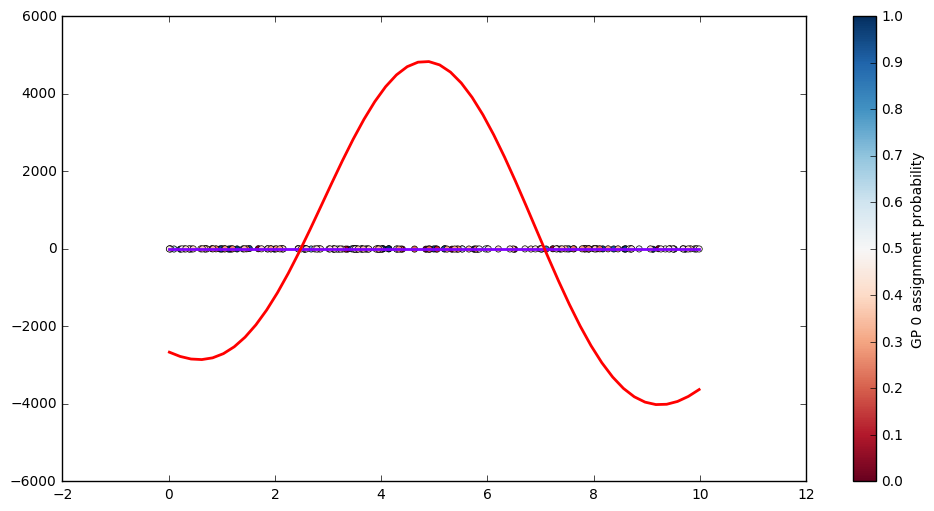

In [30]:
OMGPplot(m,x,y)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

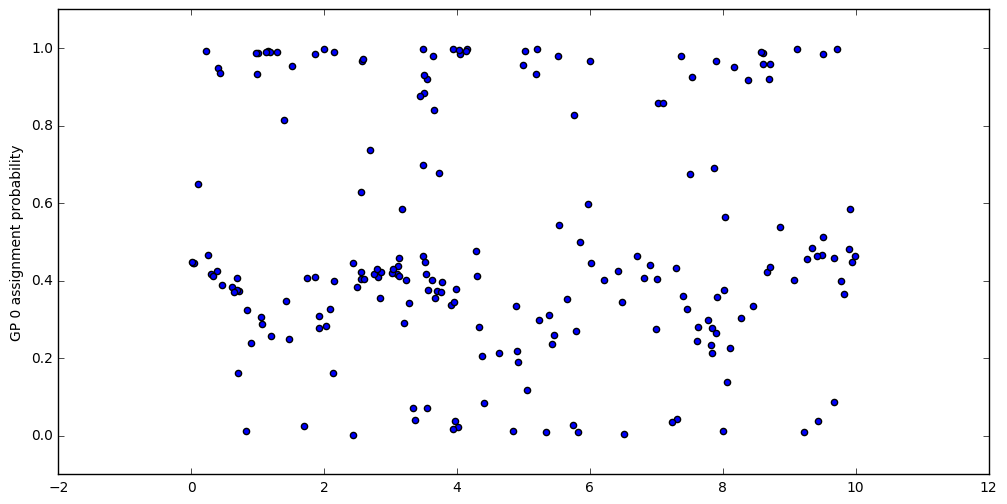

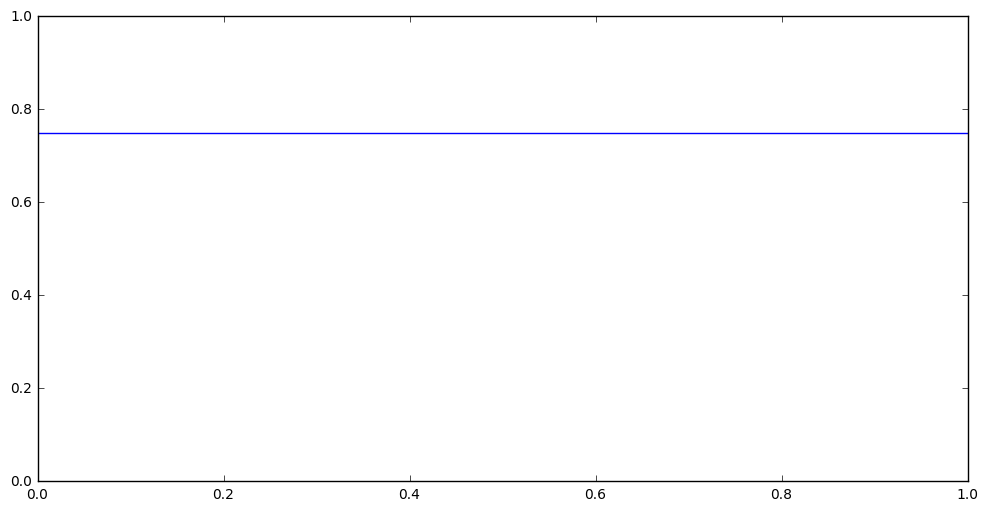

In [31]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [33]:
thr = 0.75
phi = m.get_phi()
idx = np.where(phi[:,0] < thr)[0]
nidx = np.where(phi[:,0] >= thr)[0]

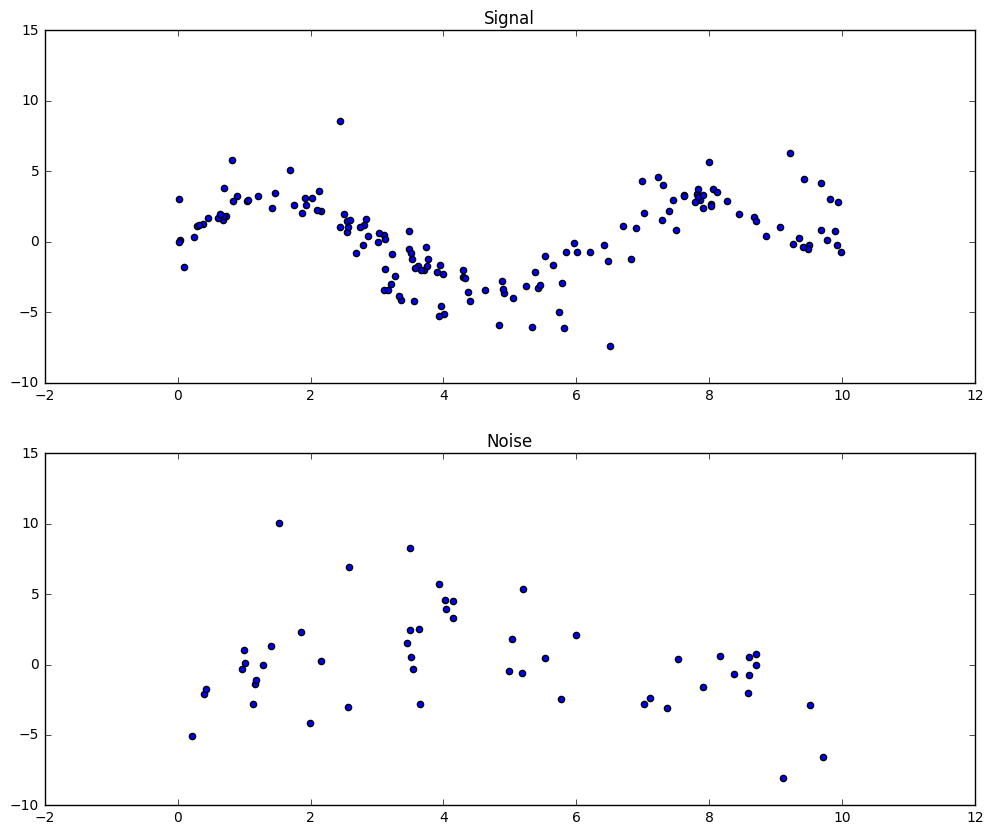

In [34]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');